In [2]:
import os
from glob import glob

cwd = os.getcwd()
data_path = glob(cwd+"/Data/data_road/training/image_2/um_*")
data_path = sorted(data_path)

import matplotlib.image as mpimg
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import misc
import cv2

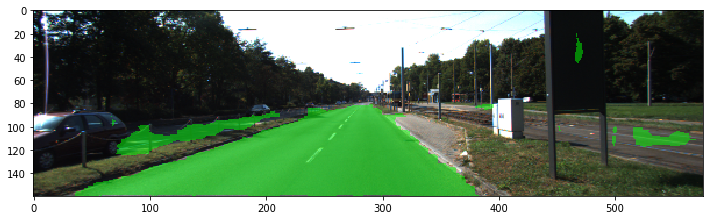

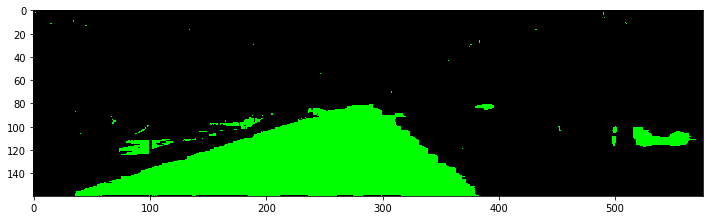

In [3]:
seg_img = mpimg.imread('/home/mikep/Documents/Udacity/Autonomous/Udacity-Autonomous-Car-Term3/Semantic_Segmentation/runs/1509655397.33/um_000000.png')
plt.figure(figsize=(12,12))
plt.imshow(seg_img)
plt.show()

seg_ind = np.zeros_like(seg_img)
h = seg_img.shape[0]
w = seg_img.shape[1]
for i in range(h):
    for j in range(w):
        r = seg_img[i,j,0]
        g = seg_img[i,j,1]
        b = seg_img[i,j,2]
        if r < .5 and g > .6 and b < .5:
            seg_ind[i,j,1] = 1
plt.figure(figsize=(12,12))
plt.imshow(seg_ind)
plt.show()
plt.imsave('seg.png', seg_ind)

ind_img = []
for i in range(h):
    for j in range(w):
        if seg_ind[i,j,1] == 1:
            ind_img.append([i,j])

In [30]:
#N = 3000
N = 10
T = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            T[i,j] = 1

scale = int(.1 * N)
index = []
for i in range(N):
    temp = []
    for j in reversed(range(scale+1)):
        ind = i - j
        if ind >= 0:
            temp.append(ind)
    for j in range(1,scale+1,1):
        ind = i + j
        if ind <= (N - 1):
            temp.append(ind)
    index.append(temp)

def norm(x, m, s=.5):
    V = s**2
    output = (1/np.sqrt(2 * 3.14 * V) * np.exp(-(x - m)**2/(2*V)))
    
    return output

for i, change in enumerate(index):
    for j in change:
        out = norm(j, i)
        T[i,j] = out
    s = np.sum(T[i,:])
    for j in range(N):
        T[i,j] /= s

np.set_printoptions(precision=1)
#print(T)


evidence = 3
S = np.zeros(N)
for i in range(N):
    if (i >= evidence - scale) and (i <= evidence + scale):
        S[i] = norm(i, evidence)

S = np.divide(S, np.sum(S))
        
print(S)

[ 0.   0.   0.1  0.8  0.1  0.   0.   0.   0.   0. ]


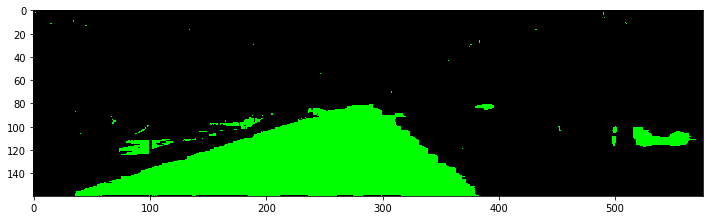

In [5]:
seg_ind = np.zeros_like(seg_img)
h = seg_img.shape[0]
w = seg_img.shape[1]
for i in range(h):
    for j in range(w):
        r = seg_img[i,j,0]
        g = seg_img[i,j,1]
        b = seg_img[i,j,2]
        if r < .5 and g > .6 and b < .5:
            seg_ind[i,j,1] = 1          
plt.figure(figsize=(12,12))
plt.imshow(seg_ind)
plt.show()

misc.imsave("bad_output.png", seg_ind)

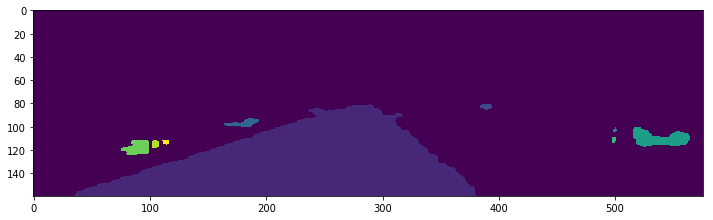

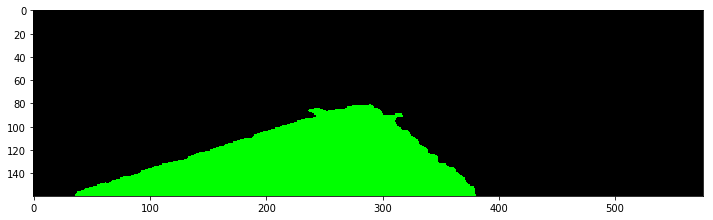

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [28]:
# convert image to grayscale
img = cv2.cvtColor(seg_ind, cv2.COLOR_BGR2GRAY)
cvuint8 = cv2.convertScaleAbs(img)

# blur that shit
cvuint8 = cv2.GaussianBlur(cvuint8,(7,7),0)

# find connected components
labels, temp_cc = cv2.connectedComponents(cvuint8, 4)

cc = np.stack((temp_cc, temp_cc, temp_cc), axis=2)

cc = cc.astype(np.float32)



plt.figure(figsize=(12,12))
plt.imshow(temp_cc)
plt.show()

#misc.imsave("connected_component.png", cc)
plt.imsave("connected_component.png", temp_cc)

# find out how many pixels belong to each component
s = []
for i in range(labels):
    temp = np.argwhere(i == cc)
    temp_s = np.sum(temp)
    s.append([temp_s, temp])
    
# get the second largest group of connected pixels
s.sort(reverse=True)
lane = s[1][1]

# create a new image with only those pixels
temp_out = np.zeros_like(img)
for i in range(len(lane)):
    temp_out[lane[i][0]][lane[i][1]] = 1
    
stack = np.zeros_like(temp_out)
out = np.stack((stack, temp_out, stack), axis=2)
    
plt.figure(figsize=(12,12))
plt.imshow(out)
plt.show()

misc.imsave("selected.png", out)